In [2]:
try:
  from einops import rearrange
except:
  !pip install einops
  from einops import rearrange

import torch
import torch.nn as nn


class Conv2x2(nn.Module):
    """
    2x2 Convolution
    """
    def __init__(self, in_channels, out_channels, stride = 1):
        super(Conv2x2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2,stride = stride, padding = 0, bias = True)

    def forward(self, x):
        result = self.conv(x)
        return result


class DWCONV(nn.Module):
    """
    Depthwise Convolution
    """
    def __init__(self, in_channels, out_channels, stride = 1):
        super(DWCONV, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, groups = in_channels, bias = True)

    def forward(self, x):
        result = self.depthwise(x)
        return result


class LPU(nn.Module):
    """
    Local Perception Unit to extract local infomation.
    LPU(X) = DWConv(X) + X
    """
    def __init__(self, in_channels, out_channels):
        super(LPU, self).__init__()
        self.DWConv = DWCONV(in_channels, out_channels)

    def forward(self, x):
        result = self.DWConv(x) + x
        return result


class LMHSA(nn.Module):
    """
    Lightweight Multi-head-self-attention module.

    Inputs:
        Q: [N, C, H, W]
        K: [N, C, H / stride, W / stride]
        V: [N, C, H / stride, W / stride]
    Outputs:
        X: [N, C, H, W]
    """
    def __init__(self, input_size, channels, d_k, d_v, stride, heads, dropout):
        super(LMHSA, self).__init__()
        self.dwconv_k = DWCONV(channels, channels, stride = stride)
        self.dwconv_v = DWCONV(channels, channels, stride = stride)
        self.fc_q = nn.Linear(channels, heads * d_k)
        self.fc_k = nn.Linear(channels, heads * d_k)
        self.fc_v = nn.Linear(channels, heads * d_v)
        self.fc_o = nn.Linear(heads * d_k, channels)

        self.channels = channels
        self.d_k = d_k
        self.d_v = d_v
        self.stride = stride
        self.heads = heads
        self.dropout = dropout
        self.scaled_factor = self.d_k ** -0.5
        self.num_patches = (self.d_k // self.stride) ** 2
        self.B = nn.Parameter(torch.Tensor(1, self.heads, input_size ** 2, (input_size // stride) ** 2), requires_grad = True)


    def forward(self, x):
        b, c, h, w = x.shape

        # Reshape
        x_reshape = x.view(b, c, h * w).permute(0, 2, 1)
        # x_reshape = nn.LayerNorm(c).cuda()(x_reshape)
        x_reshape = torch.nn.functional.layer_norm(x_reshape, (b, h * w, c))

        # Get q, k, v
        q = self.fc_q(x_reshape)
        q = q.view(b, h * w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()  # [b, heads, h * w, d_k]

        k = self.dwconv_k(x)
        k_b, k_c, k_h, k_w = k.shape
        k = k.view(k_b, k_c, k_h * k_w).permute(0, 2, 1).contiguous()
        k = self.fc_k(k)
        k = k.view(k_b, k_h * k_w, self.heads, self.d_k).permute(0, 2, 1, 3).contiguous()  # [b, heads, k_h * k_w, d_k]

        v = self.dwconv_v(x)
        v_b, v_c, v_h, v_w = v.shape
        v = v.view(v_b, v_c, v_h * v_w).permute(0, 2, 1).contiguous()
        v = self.fc_v(v)
        v = v.view(v_b, v_h * v_w, self.heads, self.d_v).permute(0, 2, 1, 3).contiguous() # [b, heads, v_h * v_w, d_v]

        # Attention
        attn = torch.einsum('... i d, ... j d -> ... i j', q, k) * self.scaled_factor
        attn = attn + self.B
        attn = torch.softmax(attn, dim = -1) # [b, heads, h * w, k_h * k_w]

        result = torch.matmul(attn, v).permute(0, 2, 1, 3)
        result = result.contiguous().view(b, h * w, self.heads * self.d_v)
        result = self.fc_o(result).view(b, self.channels, h, w)
        result = result + x
        return result


class IRFFN(nn.Module):
    """
    Inverted Residual Feed-forward Network
    """
    def __init__(self, in_channels, R):
        super(IRFFN, self).__init__()
        exp_channels = int(in_channels * R)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, exp_channels, kernel_size = 1),
            nn.BatchNorm2d(exp_channels),
            nn.GELU()
        )

        self.dwconv = nn.Sequential(
            DWCONV(exp_channels, exp_channels),
            nn.BatchNorm2d(exp_channels),
            nn.GELU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(exp_channels, in_channels, 1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        result = x + self.conv2(self.dwconv(self.conv1(x)))
        return result


class Patch_Aggregate(nn.Module):
    """
    Aggregate the patches into a single image.
    To produce the hierachical representation.

    Applied before each stage to reduce the size of intermediate features
    (2x downsampling of resolution), and project it to a larger dimension
    (2x enlargement of dimension).

    Input:
        - x: (B, In_C, H, W)
    Output:
        - x: (B, Out_C, H / 2, W / 2)
    """
    def __init__(self, in_channels, out_channels = None):
        super(Patch_Aggregate, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        self.conv = Conv2x2(in_channels, out_channels, stride = 2)
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.LayerNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        _, c, h, w = x.size()
        # result = nn.LayerNorm((c, h, w)).cuda()(x)
        result = torch.nn.functional.layer_norm(x, (c, h, w))
        return result


class CMTStem(nn.Module):
    """
    Use CMTStem module to process input image and overcome the limitation of the
    non-overlapping patches.

    First past through the image with a 2x2 convolution to reduce the image size.
    Then past throught two 1x1 convolution for better local information.

    Input:
        - x: (B, 3, H, W)
    Output:
        - result: (B, 32, H / 2, W / 2)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias = False)
        self.gelu1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu3 = nn.GELU()
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.conv1(x)
        x = self.gelu1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.gelu2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.gelu3(x)
        result = self.bn3(x)
        return result


class CMTBlock(nn.Module):
    def __init__(self, img_size, stride, d_k, d_v, num_heads, R, in_channels):
        super(CMTBlock, self).__init__()

        # Local Perception Unit
        self.lpu = LPU(in_channels, in_channels)

        # Lightweight MHSA
        self.lmhsa = LMHSA(img_size, in_channels, d_k, d_v, stride, num_heads, 0.0)

        # Inverted Residual FFN
        self.irffn = IRFFN(in_channels, R)

    def forward(self, x):
        x = self.lpu(x)
        x = self.lmhsa(x)
        x = self.irffn(x)
        return x


ModuleNotFoundError: No module named 'torch'

In [6]:
import torch
import torch.nn as nn

# from cmt_module import CMTStem, Patch_Aggregate, CMTBlock

class CMT(nn.Module):
    def __init__(self,
        in_channels = 3,
        stem_channel = 32,
        cmt_channel = [64, 128, 256, 512],
        patch_channel = [64, 128, 256, 512],
        block_layer = [3, 3, 16, 3],
        R = 4,
        img_size = 224,
        num_class = 10
    ):
        super(CMT, self).__init__()

        # Image size for each stage
        size = [img_size // 4, img_size // 8, img_size // 16, img_size // 32]

        # Stem layer
        self.stem = CMTStem(in_channels, stem_channel)

        # Patch Aggregation Layer
        self.patch1 = Patch_Aggregate(stem_channel, patch_channel[0])
        self.patch2 = Patch_Aggregate(patch_channel[0], patch_channel[1])
        self.patch3 = Patch_Aggregate(patch_channel[1], patch_channel[2])
        self.patch4 = Patch_Aggregate(patch_channel[2], patch_channel[3])

        # CMT Block Layer
        stage1 = []
        for _ in range(block_layer[0]):
            cmt_layer = CMTBlock(
                    img_size = size[0],
                    stride = 8,
                    d_k = cmt_channel[0],
                    d_v = cmt_channel[0],
                    num_heads = 1,
                    R = R,
                    in_channels = patch_channel[0]
            )
            stage1.append(cmt_layer)
        self.stage1 = nn.Sequential(*stage1)

        stage2 = []
        for _ in range(block_layer[1]):
            cmt_layer = CMTBlock(
                    img_size = size[1],
                stride = 4,
                d_k = cmt_channel[1] // 2,
                d_v = cmt_channel[1] // 2,
                num_heads = 2,
                R = R,
                in_channels = patch_channel[1]
            )
            stage2.append(cmt_layer)
        self.stage2 = nn.Sequential(*stage2)

        stage3 = []
        for _ in range(block_layer[2]):
            cmt_layer = CMTBlock(
                img_size = size[2],
                stride = 2,
                d_k = cmt_channel[2] // 4,
                d_v = cmt_channel[2] // 4,
                num_heads = 4,
                R = R,
                in_channels = patch_channel[2]
            )
            stage3.append(cmt_layer)
        self.stage3 = nn.Sequential(*stage3)

        stage4 = []
        for _ in range(block_layer[3]):
            cmt_layer = CMTBlock(
                img_size = size[3],
                stride = 1,
                d_k = cmt_channel[3] // 8,
                d_v = cmt_channel[3] // 8,
                num_heads = 8,
                R = R,
                in_channels = patch_channel[3]
            )
            stage4.append(cmt_layer)
        self.stage4 = nn.Sequential(*stage4)

        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # FC
        self.fc = nn.Sequential(
            nn.Linear(64, 1280),
            nn.ReLU(inplace = True),
        )

        # Final Classifier
        self.classifier = nn.Linear(1280, num_class)


    def forward(self, x):
        # print(f"Shape before STEM: {x.shape}")
        x = self.stem(x)
        # print(f"Shape after STEM: {x.shape}")
        # print()

        # print(f"Shape before Patch-Aggregation 1: {x.shape}")
        x = self.patch1(x)
        # print(f"Shape after Patch-Aggregation 1: {x.shape}")
        # print()
        # print(f"Shape before Block 1: {x.shape}")
        x = self.stage1(x)
        # print(f"Shape after Block 1: {x.shape}")

        # x = self.patch2(x)
        # x = self.stage2(x)

        # x = self.patch3(x)
        # x = self.stage3(x)

        # x = self.patch4(x)
        # x = self.stage4(x)

        # print(f"Shape before avg pool: {x.shape}")
        x = self.avg_pool(x)
        # print(f"Shape after avg pool: {x.shape}")
        x = torch.flatten(x, 1)
        # print(f"Shape after flatten: {x.shape}")

        x = self.fc(x)
        # print(f"Shape after fc: {x.shape}")
        # print()
        logit = self.classifier(x)
        # print(f"Final Shape- STEM->PA1->Block1->AvgPool->Classifier: {logit.shape}")
        # print()
        return logit


def CMT_Ti(img_size = 224, num_class = 10):
    model = CMT(
        in_channels = 3,
        stem_channel = 16,
        cmt_channel = [46, 92, 184, 368],
        patch_channel = [46, 92, 184, 368],
        block_layer = [2, 2, 10, 2],
        R = 3.6,
        img_size = img_size,
        num_class = num_class
    )
    return model


def CMT_XS(img_size = 224, num_class = 10):
    model = CMT(
        in_channels = 3,
        stem_channel = 16,
        cmt_channel = [52, 104, 208, 416],
        patch_channel = [52, 104, 208, 416],
        block_layer = [3, 3, 12, 3],
        R = 3.8,
        img_size = img_size,
        num_class = num_class
    )
    return model

def CMT_S(img_size = 224, num_class = 10):
    model = CMT(
        in_channels = 3,
        stem_channel = 32,
        cmt_channel = [64, 128, 256, 512],
        patch_channel = [64, 128, 256, 512],
        block_layer = [3, 3, 16, 3],
        R = 4,
        img_size = img_size,
        num_class = num_class
    )
    return model

def CMT_B(img_size = 224, num_class = 10):
    model = CMT(
        in_channels = 3,
        stem_channel = 38,
        cmt_channel = [76, 152, 304, 608],
        patch_channel = [76, 152, 304, 608],
        block_layer = [4, 4, 20, 4],
        R = 4,
        img_size = img_size,
        num_class = num_class
    )
    return model


def test():
    calc_param = lambda net: sum(p.numel() for p in net.parameters() if p.requires_grad)
    img = torch.rand(2, 3, 224, 224)
    cmt_ti = CMT_Ti()
    cmt_xs = CMT_XS()
    cmt_x = CMT_S()
    cmt_b = CMT_B()
    logit = cmt_b(img)
    print(logit.size())
    print(f"CMT_Ti param: {calc_param(cmt_ti) / 1e6 : .2f} M")
    print(f"CMT_XS param: {calc_param(cmt_xs) / 1e6 : .2f} M")
    print(f"CMT_X  param: {calc_param(cmt_x) / 1e6 : .2f} M")
    print(f"CMT_B  param: {calc_param(cmt_b) / 1e6 : .2f} M")

if __name__ == "__main__":
    x = torch.randn(1, 3, 224, 224)
    model = CMT_S()

    # print(model)
    # print("---------------------------")
    # print()
    out = model(x)
    print(f"Final shape of output: {out.shape}")

Final shape of output: torch.Size([1, 10])


In [7]:
from typing import List, Optional
import os
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms as T

class AverageMeter(object):
    def __init__(self,
        name: str,
        fmt: Optional[str] = ':f',
    ) -> None:
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self,
        val: float,
        n: Optional[int] = 1
    ) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name}:{val' + self.fmt + '}({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self,
        num_batches: int,
        meters: List[AverageMeter],
        prefix: Optional[str] = "",
        batch_info: Optional[str] = ""
    ) -> None:
        self.batch_fmster = self._get_batch_fmster(num_batches)
        self.meters = meters
        self.prefix = prefix
        self.batch_info = batch_info

    def display(self, batch):
        self.info = [self.prefix + self.batch_info + self.batch_fmster.format(batch)]
        self.info += [str(meter) for meter in self.meters]
        print('\t'.join(self.info))

    def _get_batch_fmster(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


class EarlyStopping(object):
    """
    Arg
    """
    def __init__(self,
        patience: int = 7,
        verbose: Optional[bool] = False,
        delta: Optional[float] = 0.0,
        path: Optional[str] = "checkpoint.pt"
    ) -> None:
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop_flag = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.verbose = verbose
        self.path = path

    def __call__(self, val_loss, model):
        score = abs(val_loss)
        if self.best_score is None:
            self.best_score = score
            self.save_model(val_loss, model)
        elif val_loss > self.val_loss_min + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping Counter: {self.counter} out of {self.patience}")
                print(f"Best val loss: {self.val_loss_min}  Current val loss: {score}")
            if self.counter >= self.patience:
                self.early_stop_flag = True
        else:
            self.best_score = score
            self.save_model(val_loss, model)
            self.counter = 0

    def save_model(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def accuracy(output, target, topk = (1,)):
    """
    Computes the accuracy over the top k predictions
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = output.size(0)

        _, pred = output.topk(max_k,
            dim = 1,
            largest = True,
            sorted = True
        )
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        result = []
        for k in topk:
            correct_k = correct[: k].contiguous().view(-1).float().sum(0, keepdim = True)
            result.append(correct_k.mul_(100.0 / batch_size))
        return result


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def get_cifar10_dataset(train_transform = None, test_transform = None):
    train_dataset =  datasets.CIFAR10(
        root = './data',
        train = True,
        transform = train_transform,
        download = True
    )
    test_dataset = datasets.CIFAR10(
        root = './data',
        train = False,
        transform = test_transform,
        download = True
    )
    return train_dataset, test_dataset


def get_dataloader(
        train_transform,
        test_transform,
        img_size = 224,
        split = (0.8, 0.2),
        **kwargs
    ):
    assert len(split) == 2
    assert sum(split) == 1
    assert split[0] + split[1] == 1

    train_dataset, test_dataset = get_cifar10_dataset(train_transform, test_transform)
    train_size = int(len(train_dataset) * split[0])
    test_size = int(len(train_dataset) * split[1])
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset,
        (train_size, test_size)
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4,
        pin_memory = True,
        drop_last = True,
        sampler = None
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size = 64,
        shuffle = False,
        num_workers = 4,
        pin_memory = True,
        drop_last = False,
        sampler = None
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = 64,
        shuffle = False,
        num_workers = 4,
        pin_memory = True,
        drop_last = False,
        sampler = None
    )
    return train_loader, val_loader, test_loader

train_transform = T.Compose([
    T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

test_transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

kwargs = {
    'batch_size': 64,
    'num_workers': 4,
}

train_loader, val_loader, test_loader = get_dataloader(
    train_transform,
    train_transform,
    img_size = 224,
    split = (0.8, 0.2),
    **kwargs
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch

# Clear GPU cache
torch.cuda.empty_cache()

import gc

# Clear variables and garbage collection
gc.collect()

18

In [9]:
import os
import argparse
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms as T
from google.colab import drive
drive.mount('/content/drive')


def train_epoch(epoch, net, train_loader, val_loader , criterion, optimizer, scheduler, device):
    """
    Training logic for an epoch
    """
    train_loss = AverageMeter("Epoch losses", ":.4e")
    # print(f"Train Loss: {train_loss}")
    train_acc1 = AverageMeter("Train Acc@1", ":6.2f")
    train_acc5 = AverageMeter("Train Acc@5", ":6.2f")
    net.train()

    for _, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # print(f"Train Loss loop: {train_loss}")
        acc1, acc5 = accuracy(outputs, targets, topk = (1, 5))

        train_loss.update(loss.item(), inputs.size(0))
        train_acc1.update(acc1.item(), inputs.size(0))
        train_acc5.update(acc5.item(), inputs.size(0))

        # Backward and optimize

        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
        optimizer.step()
    scheduler.step()


    # Validation model
    val_loss = AverageMeter("Val losses", ":.4e")
    val_acc1 = AverageMeter("Val Acc@1", ":6.2f")
    val_acc5 = AverageMeter("Val Acc@5", ":6.2f")
    progress = ProgressMeter(
        num_batches = len(val_loader),
        meters = [val_loss, val_acc1, val_acc5],
        prefix = 'Epoch: {} '.format(epoch + 1),
        batch_info = " Iter"
    )
    net.eval()

    for it, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # print(f"lossy: {loss}")
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        val_loss.update(loss.item(), inputs.size(0))
        val_acc1.update(acc1.item(), inputs.size(0))
        val_acc5.update(acc5.item(), inputs.size(0))
        progress.display(it)

    return val_loss.avg, val_acc1.avg, val_acc5.avg


if __name__ == "__main__":
    epochs = 50

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Cifar10 Dataloader
    kwargs = {
        'batch_size': 64,
        'num_workers': 4,
    }
    train_transform = T.Compose([
        T.RandomCrop(32, padding = 4),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
    ])
    test_transform = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
    ])

    train_loader, valid_loader, test_loader = get_dataloader(
        train_transform,
        test_transform,
        img_size = 224,
        **kwargs
    )

    # Create model
    net = CMT_S()
    net.to(device)

    # Set loss function and optimizer
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.functional.cross_entropy
    optimizer = torch.optim.AdamW(net.parameters(), lr = 1e-05, weight_decay = 1e-05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    print(f"Epochs: {epochs}")
    print(f"Device: {device}")
    print(f"tLoader: {len(train_loader)}")

    # Train the model
    checkpoint_interval = 1  # Save checkpoint every epoch
    checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint.pth'
    output = []
    for epoch in tqdm(range(epochs)):
        loss, acc1, acc5 = train_epoch(epoch, net, train_loader,
            valid_loader, criterion, optimizer, scheduler, device
        )
        output.append((epoch,loss,acc1,acc5))
        print(f"Epoch {epoch} -> Loss: {loss}, Acc@1: {acc1}, Acc@5: {acc5}")

        # Save model checkpoint
        if epoch % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'output': output
            }, checkpoint_path)

    print("Training is done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
Epochs: 50
Device: cuda
tLoader: 625


100%|██████████| 625/625 [05:38<00:00,  1.85it/s]


Epoch: 1  Iter[  0/157]	Val losses:1.8674e+00(1.8674e+00)	Val Acc@1: 29.69( 29.69)	Val Acc@5: 82.81( 82.81)
Epoch: 1  Iter[  1/157]	Val losses:1.8213e+00(1.8443e+00)	Val Acc@1: 28.12( 28.91)	Val Acc@5: 82.81( 82.81)
Epoch: 1  Iter[  2/157]	Val losses:1.8690e+00(1.8525e+00)	Val Acc@1: 25.00( 27.60)	Val Acc@5: 87.50( 84.38)
Epoch: 1  Iter[  3/157]	Val losses:2.0330e+00(1.8977e+00)	Val Acc@1: 17.19( 25.00)	Val Acc@5: 78.12( 82.81)
Epoch: 1  Iter[  4/157]	Val losses:1.8099e+00(1.8801e+00)	Val Acc@1: 25.00( 25.00)	Val Acc@5: 81.25( 82.50)
Epoch: 1  Iter[  5/157]	Val losses:1.9124e+00(1.8855e+00)	Val Acc@1: 20.31( 24.22)	Val Acc@5: 85.94( 83.07)
Epoch: 1  Iter[  6/157]	Val losses:2.0311e+00(1.9063e+00)	Val Acc@1: 23.44( 24.11)	Val Acc@5: 78.12( 82.37)
Epoch: 1  Iter[  7/157]	Val losses:2.1167e+00(1.9326e+00)	Val Acc@1: 18.75( 23.44)	Val Acc@5: 70.31( 80.86)
Epoch: 1  Iter[  8/157]	Val losses:1.9651e+00(1.9362e+00)	Val Acc@1: 32.81( 24.48)	Val Acc@5: 82.81( 81.08)
Epoch: 1  Iter[  9/157]	Val 

100%|██████████| 625/625 [05:38<00:00,  1.84it/s]


Epoch: 2  Iter[  0/157]	Val losses:1.7453e+00(1.7453e+00)	Val Acc@1: 32.81( 32.81)	Val Acc@5: 87.50( 87.50)
Epoch: 2  Iter[  1/157]	Val losses:1.7229e+00(1.7341e+00)	Val Acc@1: 32.81( 32.81)	Val Acc@5: 85.94( 86.72)
Epoch: 2  Iter[  2/157]	Val losses:1.7777e+00(1.7487e+00)	Val Acc@1: 28.12( 31.25)	Val Acc@5: 85.94( 86.46)
Epoch: 2  Iter[  3/157]	Val losses:1.9125e+00(1.7896e+00)	Val Acc@1: 23.44( 29.30)	Val Acc@5: 82.81( 85.55)
Epoch: 2  Iter[  4/157]	Val losses:1.6530e+00(1.7623e+00)	Val Acc@1: 37.50( 30.94)	Val Acc@5: 90.62( 86.56)
Epoch: 2  Iter[  5/157]	Val losses:1.8242e+00(1.7726e+00)	Val Acc@1: 28.12( 30.47)	Val Acc@5: 82.81( 85.94)
Epoch: 2  Iter[  6/157]	Val losses:1.9306e+00(1.7952e+00)	Val Acc@1: 26.56( 29.91)	Val Acc@5: 85.94( 85.94)
Epoch: 2  Iter[  7/157]	Val losses:2.0240e+00(1.8238e+00)	Val Acc@1: 29.69( 29.88)	Val Acc@5: 73.44( 84.38)
Epoch: 2  Iter[  8/157]	Val losses:1.9233e+00(1.8348e+00)	Val Acc@1: 31.25( 30.03)	Val Acc@5: 82.81( 84.20)
Epoch: 2  Iter[  9/157]	Val 

  4%|▍         | 2/50 [14:35<5:50:01, 437.53s/it]


KeyboardInterrupt: ignored

In [ ]:
import os
import argparse
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms as T
from google.colab import drive
drive.mount('/content/drive')


def train_epoch(epoch, net, train_loader, val_loader , criterion, optimizer, scheduler, device):
    """
    Training logic for an epoch
    """
    train_loss = AverageMeter("Epoch losses", ":.4e")
    train_acc1 = AverageMeter("Train Acc@1", ":6.2f")
    train_acc5 = AverageMeter("Train Acc@5", ":6.2f")
    net.train()

    for _, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        acc1, acc5 = accuracy(outputs, targets, topk = (1, 5))

        train_loss.update(loss.item(), inputs.size(0))
        train_acc1.update(acc1.item(), inputs.size(0))
        train_acc5.update(acc5.item(), inputs.size(0))

        # Backward and optimize
        loss.backward()
        optimizer.step()
    scheduler.step()


    # Validation model
    val_loss = AverageMeter("Val losses", ":.4e")
    val_acc1 = AverageMeter("Val Acc@1", ":6.2f")
    val_acc5 = AverageMeter("Val Acc@5", ":6.2f")
    progress = ProgressMeter(
        num_batches = len(val_loader),
        meters = [val_loss, val_acc1, val_acc5],
        prefix = 'Epoch: {} '.format(epoch + 1),
        batch_info = " Iter"
    )
    net.eval()

    for it, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        val_loss.update(loss.item(), inputs.size(0))
        val_acc1.update(acc1.item(), inputs.size(0))
        val_acc5.update(acc5.item(), inputs.size(0))
        progress.display(it)

    return val_loss.avg, val_acc1.avg, val_acc5.avg


if __name__ == "__main__":
    epochs = 101

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Cifar10 Dataloader
    kwargs = {
        'batch_size': 64,
        'num_workers': 4,
    }
    train_transform = T.Compose([
        T.RandomCrop(32, padding = 4),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
    ])
    test_transform = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
    ])

    train_loader, valid_laoder, test_loader = get_dataloader(
        train_transform,
        test_transform,
        img_size = 224,
        **kwargs
    )

    # Create model
    net = CMT_S(img_size = 224, num_class = 10)
    net.to(device)

    # Set loss function and optimizer
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.functional.cross_entropy
    optimizer = torch.optim.AdamW(net.parameters(), lr = 6e-05, weight_decay = 1e-05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    print(f"Epochs: {epochs}")
    print(f"Device: {device}")
    print(f"tLoader: {len(train_loader)}")

    # Load checkpoint
    checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint.pth'
    checkpoint = torch.load(checkpoint_path)
    start_epoch = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    output = checkpoint['output']  # Load the output list

    print(f"Start Epoch: {start_epoch}")

    # Train the model
    checkpoint_interval = 1  # Save checkpoint every epoch
    for epoch in tqdm(range(start_epoch, epochs)):
        loss, acc1, acc5 = train_epoch(epoch, net, train_loader,
            valid_laoder, criterion, optimizer, scheduler, device
        )
        output.append((epoch,loss,acc1,acc5))
        print(f"Epoch {epoch} ->  Loss: {loss}, Acc@1: {acc1}, Acc@5: {acc5}")

        # Save model checkpoint
        if epoch % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'output': output
            }, checkpoint_path)

    print("Training is done")

Mounted at /content/drive
Files already downloaded and verified
Files already downloaded and verified
Epochs: 101
Device: cuda
tLoader: 625
Start Epoch: 52


100%|██████████| 625/625 [05:29<00:00,  1.89it/s]


Epoch: 53  Iter[  0/157]	Val losses:7.1434e-01(7.1434e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5: 98.44( 98.44)
Epoch: 53  Iter[  1/157]	Val losses:9.6677e-01(8.4056e-01)	Val Acc@1: 59.38( 67.97)	Val Acc@5:100.00( 99.22)
Epoch: 53  Iter[  2/157]	Val losses:6.9356e-01(7.9156e-01)	Val Acc@1: 68.75( 68.23)	Val Acc@5:100.00( 99.48)
Epoch: 53  Iter[  3/157]	Val losses:6.1955e-01(7.4856e-01)	Val Acc@1: 75.00( 69.92)	Val Acc@5:100.00( 99.61)
Epoch: 53  Iter[  4/157]	Val losses:7.1992e-01(7.4283e-01)	Val Acc@1: 76.56( 71.25)	Val Acc@5: 96.88( 99.06)
Epoch: 53  Iter[  5/157]	Val losses:8.0263e-01(7.5280e-01)	Val Acc@1: 70.31( 71.09)	Val Acc@5:100.00( 99.22)
Epoch: 53  Iter[  6/157]	Val losses:6.8788e-01(7.4352e-01)	Val Acc@1: 73.44( 71.43)	Val Acc@5: 98.44( 99.11)
Epoch: 53  Iter[  7/157]	Val losses:7.5675e-01(7.4518e-01)	Val Acc@1: 76.56( 72.07)	Val Acc@5: 96.88( 98.83)
Epoch: 53  Iter[  8/157]	Val losses:8.8321e-01(7.6051e-01)	Val Acc@1: 76.56( 72.57)	Val Acc@5: 96.88( 98.61)
Epoch: 53  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 54  Iter[  0/157]	Val losses:6.0976e-01(6.0976e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5:100.00(100.00)
Epoch: 54  Iter[  1/157]	Val losses:8.3372e-01(7.2174e-01)	Val Acc@1: 68.75( 72.66)	Val Acc@5: 98.44( 99.22)
Epoch: 54  Iter[  2/157]	Val losses:7.6255e-01(7.3534e-01)	Val Acc@1: 67.19( 70.83)	Val Acc@5: 98.44( 98.96)
Epoch: 54  Iter[  3/157]	Val losses:6.1109e-01(7.0428e-01)	Val Acc@1: 78.12( 72.66)	Val Acc@5:100.00( 99.22)
Epoch: 54  Iter[  4/157]	Val losses:7.7366e-01(7.1816e-01)	Val Acc@1: 73.44( 72.81)	Val Acc@5:100.00( 99.38)
Epoch: 54  Iter[  5/157]	Val losses:7.9775e-01(7.3142e-01)	Val Acc@1: 73.44( 72.92)	Val Acc@5:100.00( 99.48)
Epoch: 54  Iter[  6/157]	Val losses:5.5835e-01(7.0670e-01)	Val Acc@1: 81.25( 74.11)	Val Acc@5:100.00( 99.55)
Epoch: 54  Iter[  7/157]	Val losses:8.0245e-01(7.1867e-01)	Val Acc@1: 68.75( 73.44)	Val Acc@5: 98.44( 99.41)
Epoch: 54  Iter[  8/157]	Val losses:7.7987e-01(7.2547e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5: 98.44( 99.31)
Epoch: 54  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 55  Iter[  0/157]	Val losses:6.3562e-01(6.3562e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  1/157]	Val losses:8.1049e-01(7.2305e-01)	Val Acc@1: 65.62( 69.53)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  2/157]	Val losses:6.9889e-01(7.1500e-01)	Val Acc@1: 71.88( 70.31)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  3/157]	Val losses:7.4739e-01(7.2310e-01)	Val Acc@1: 73.44( 71.09)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  4/157]	Val losses:6.9228e-01(7.1693e-01)	Val Acc@1: 75.00( 71.88)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  5/157]	Val losses:8.0779e-01(7.3208e-01)	Val Acc@1: 70.31( 71.61)	Val Acc@5:100.00(100.00)
Epoch: 55  Iter[  6/157]	Val losses:6.4770e-01(7.2002e-01)	Val Acc@1: 78.12( 72.54)	Val Acc@5: 98.44( 99.78)
Epoch: 55  Iter[  7/157]	Val losses:6.9640e-01(7.1707e-01)	Val Acc@1: 71.88( 72.46)	Val Acc@5:100.00( 99.80)
Epoch: 55  Iter[  8/157]	Val losses:8.5313e-01(7.3219e-01)	Val Acc@1: 73.44( 72.57)	Val Acc@5: 96.88( 99.48)
Epoch: 55  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 56  Iter[  0/157]	Val losses:6.9307e-01(6.9307e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5: 98.44( 98.44)
Epoch: 56  Iter[  1/157]	Val losses:8.4587e-01(7.6947e-01)	Val Acc@1: 65.62( 71.09)	Val Acc@5: 98.44( 98.44)
Epoch: 56  Iter[  2/157]	Val losses:7.7747e-01(7.7214e-01)	Val Acc@1: 70.31( 70.83)	Val Acc@5:100.00( 98.96)
Epoch: 56  Iter[  3/157]	Val losses:6.5813e-01(7.4364e-01)	Val Acc@1: 78.12( 72.66)	Val Acc@5:100.00( 99.22)
Epoch: 56  Iter[  4/157]	Val losses:6.9308e-01(7.3352e-01)	Val Acc@1: 76.56( 73.44)	Val Acc@5: 98.44( 99.06)
Epoch: 56  Iter[  5/157]	Val losses:8.7302e-01(7.5677e-01)	Val Acc@1: 62.50( 71.61)	Val Acc@5:100.00( 99.22)
Epoch: 56  Iter[  6/157]	Val losses:6.8949e-01(7.4716e-01)	Val Acc@1: 78.12( 72.54)	Val Acc@5: 98.44( 99.11)
Epoch: 56  Iter[  7/157]	Val losses:7.5400e-01(7.4802e-01)	Val Acc@1: 70.31( 72.27)	Val Acc@5: 98.44( 99.02)
Epoch: 56  Iter[  8/157]	Val losses:8.5170e-01(7.5954e-01)	Val Acc@1: 68.75( 71.88)	Val Acc@5: 98.44( 98.96)
Epoch: 56  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 57  Iter[  0/157]	Val losses:7.4377e-01(7.4377e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5: 98.44( 98.44)
Epoch: 57  Iter[  1/157]	Val losses:8.4230e-01(7.9304e-01)	Val Acc@1: 60.94( 67.19)	Val Acc@5: 98.44( 98.44)
Epoch: 57  Iter[  2/157]	Val losses:7.3140e-01(7.7249e-01)	Val Acc@1: 73.44( 69.27)	Val Acc@5:100.00( 98.96)
Epoch: 57  Iter[  3/157]	Val losses:6.7916e-01(7.4916e-01)	Val Acc@1: 73.44( 70.31)	Val Acc@5:100.00( 99.22)
Epoch: 57  Iter[  4/157]	Val losses:8.5690e-01(7.7071e-01)	Val Acc@1: 71.88( 70.62)	Val Acc@5:100.00( 99.38)
Epoch: 57  Iter[  5/157]	Val losses:7.9414e-01(7.7461e-01)	Val Acc@1: 67.19( 70.05)	Val Acc@5: 98.44( 99.22)
Epoch: 57  Iter[  6/157]	Val losses:5.0008e-01(7.3539e-01)	Val Acc@1: 81.25( 71.65)	Val Acc@5: 98.44( 99.11)
Epoch: 57  Iter[  7/157]	Val losses:7.3454e-01(7.3529e-01)	Val Acc@1: 71.88( 71.68)	Val Acc@5:100.00( 99.22)
Epoch: 57  Iter[  8/157]	Val losses:8.7026e-01(7.5028e-01)	Val Acc@1: 75.00( 72.05)	Val Acc@5: 96.88( 98.96)
Epoch: 57  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 58  Iter[  0/157]	Val losses:6.5278e-01(6.5278e-01)	Val Acc@1: 78.12( 78.12)	Val Acc@5:100.00(100.00)
Epoch: 58  Iter[  1/157]	Val losses:8.2563e-01(7.3921e-01)	Val Acc@1: 67.19( 72.66)	Val Acc@5: 98.44( 99.22)
Epoch: 58  Iter[  2/157]	Val losses:8.0163e-01(7.6001e-01)	Val Acc@1: 67.19( 70.83)	Val Acc@5: 98.44( 98.96)
Epoch: 58  Iter[  3/157]	Val losses:6.9891e-01(7.4474e-01)	Val Acc@1: 81.25( 73.44)	Val Acc@5:100.00( 99.22)
Epoch: 58  Iter[  4/157]	Val losses:7.6377e-01(7.4854e-01)	Val Acc@1: 75.00( 73.75)	Val Acc@5:100.00( 99.38)
Epoch: 58  Iter[  5/157]	Val losses:7.7254e-01(7.5254e-01)	Val Acc@1: 71.88( 73.44)	Val Acc@5: 98.44( 99.22)
Epoch: 58  Iter[  6/157]	Val losses:5.7994e-01(7.2789e-01)	Val Acc@1: 84.38( 75.00)	Val Acc@5: 98.44( 99.11)
Epoch: 58  Iter[  7/157]	Val losses:7.2989e-01(7.2814e-01)	Val Acc@1: 68.75( 74.22)	Val Acc@5:100.00( 99.22)
Epoch: 58  Iter[  8/157]	Val losses:8.6998e-01(7.4390e-01)	Val Acc@1: 68.75( 73.61)	Val Acc@5: 96.88( 98.96)
Epoch: 58  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 59  Iter[  0/157]	Val losses:7.0910e-01(7.0910e-01)	Val Acc@1: 75.00( 75.00)	Val Acc@5: 96.88( 96.88)
Epoch: 59  Iter[  1/157]	Val losses:7.9522e-01(7.5216e-01)	Val Acc@1: 67.19( 71.09)	Val Acc@5:100.00( 98.44)
Epoch: 59  Iter[  2/157]	Val losses:6.1433e-01(7.0622e-01)	Val Acc@1: 78.12( 73.44)	Val Acc@5:100.00( 98.96)
Epoch: 59  Iter[  3/157]	Val losses:7.3678e-01(7.1386e-01)	Val Acc@1: 75.00( 73.83)	Val Acc@5:100.00( 99.22)
Epoch: 59  Iter[  4/157]	Val losses:7.7814e-01(7.2671e-01)	Val Acc@1: 71.88( 73.44)	Val Acc@5:100.00( 99.38)
Epoch: 59  Iter[  5/157]	Val losses:7.6018e-01(7.3229e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5: 98.44( 99.22)
Epoch: 59  Iter[  6/157]	Val losses:6.3750e-01(7.1875e-01)	Val Acc@1: 81.25( 74.55)	Val Acc@5: 98.44( 99.11)
Epoch: 59  Iter[  7/157]	Val losses:7.6198e-01(7.2415e-01)	Val Acc@1: 70.31( 74.02)	Val Acc@5: 98.44( 99.02)
Epoch: 59  Iter[  8/157]	Val losses:9.0100e-01(7.4380e-01)	Val Acc@1: 78.12( 74.48)	Val Acc@5: 98.44( 98.96)
Epoch: 59  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 60  Iter[  0/157]	Val losses:6.1904e-01(6.1904e-01)	Val Acc@1: 79.69( 79.69)	Val Acc@5:100.00(100.00)
Epoch: 60  Iter[  1/157]	Val losses:8.1157e-01(7.1531e-01)	Val Acc@1: 65.62( 72.66)	Val Acc@5: 96.88( 98.44)
Epoch: 60  Iter[  2/157]	Val losses:7.9008e-01(7.4023e-01)	Val Acc@1: 62.50( 69.27)	Val Acc@5:100.00( 98.96)
Epoch: 60  Iter[  3/157]	Val losses:8.0020e-01(7.5522e-01)	Val Acc@1: 71.88( 69.92)	Val Acc@5:100.00( 99.22)
Epoch: 60  Iter[  4/157]	Val losses:7.5051e-01(7.5428e-01)	Val Acc@1: 75.00( 70.94)	Val Acc@5:100.00( 99.38)
Epoch: 60  Iter[  5/157]	Val losses:7.0895e-01(7.4672e-01)	Val Acc@1: 75.00( 71.61)	Val Acc@5:100.00( 99.48)
Epoch: 60  Iter[  6/157]	Val losses:6.9039e-01(7.3868e-01)	Val Acc@1: 76.56( 72.32)	Val Acc@5: 98.44( 99.33)
Epoch: 60  Iter[  7/157]	Val losses:6.4188e-01(7.2658e-01)	Val Acc@1: 79.69( 73.24)	Val Acc@5: 98.44( 99.22)
Epoch: 60  Iter[  8/157]	Val losses:1.0189e+00(7.5906e-01)	Val Acc@1: 71.88( 73.09)	Val Acc@5: 93.75( 98.61)
Epoch: 60  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 61  Iter[  0/157]	Val losses:6.8362e-01(6.8362e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5: 98.44( 98.44)
Epoch: 61  Iter[  1/157]	Val losses:7.0723e-01(6.9542e-01)	Val Acc@1: 68.75( 71.09)	Val Acc@5:100.00( 99.22)
Epoch: 61  Iter[  2/157]	Val losses:6.4210e-01(6.7765e-01)	Val Acc@1: 71.88( 71.35)	Val Acc@5:100.00( 99.48)
Epoch: 61  Iter[  3/157]	Val losses:7.0652e-01(6.8487e-01)	Val Acc@1: 71.88( 71.48)	Val Acc@5:100.00( 99.61)
Epoch: 61  Iter[  4/157]	Val losses:9.0580e-01(7.2905e-01)	Val Acc@1: 71.88( 71.56)	Val Acc@5: 98.44( 99.38)
Epoch: 61  Iter[  5/157]	Val losses:7.1224e-01(7.2625e-01)	Val Acc@1: 68.75( 71.09)	Val Acc@5:100.00( 99.48)
Epoch: 61  Iter[  6/157]	Val losses:6.5160e-01(7.1559e-01)	Val Acc@1: 71.88( 71.21)	Val Acc@5: 98.44( 99.33)
Epoch: 61  Iter[  7/157]	Val losses:7.0139e-01(7.1381e-01)	Val Acc@1: 71.88( 71.29)	Val Acc@5:100.00( 99.41)
Epoch: 61  Iter[  8/157]	Val losses:9.3795e-01(7.3872e-01)	Val Acc@1: 71.88( 71.35)	Val Acc@5: 96.88( 99.13)
Epoch: 61  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 62  Iter[  0/157]	Val losses:5.7225e-01(5.7225e-01)	Val Acc@1: 79.69( 79.69)	Val Acc@5:100.00(100.00)
Epoch: 62  Iter[  1/157]	Val losses:7.1096e-01(6.4160e-01)	Val Acc@1: 67.19( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 62  Iter[  2/157]	Val losses:6.5203e-01(6.4508e-01)	Val Acc@1: 75.00( 73.96)	Val Acc@5:100.00(100.00)
Epoch: 62  Iter[  3/157]	Val losses:6.6004e-01(6.4882e-01)	Val Acc@1: 76.56( 74.61)	Val Acc@5:100.00(100.00)
Epoch: 62  Iter[  4/157]	Val losses:7.1984e-01(6.6302e-01)	Val Acc@1: 76.56( 75.00)	Val Acc@5: 98.44( 99.69)
Epoch: 62  Iter[  5/157]	Val losses:7.7178e-01(6.8115e-01)	Val Acc@1: 71.88( 74.48)	Val Acc@5:100.00( 99.74)
Epoch: 62  Iter[  6/157]	Val losses:5.9236e-01(6.6847e-01)	Val Acc@1: 81.25( 75.45)	Val Acc@5: 98.44( 99.55)
Epoch: 62  Iter[  7/157]	Val losses:7.0548e-01(6.7309e-01)	Val Acc@1: 71.88( 75.00)	Val Acc@5: 98.44( 99.41)
Epoch: 62  Iter[  8/157]	Val losses:8.5820e-01(6.9366e-01)	Val Acc@1: 68.75( 74.31)	Val Acc@5: 98.44( 99.31)
Epoch: 62  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 63  Iter[  0/157]	Val losses:7.3466e-01(7.3466e-01)	Val Acc@1: 71.88( 71.88)	Val Acc@5: 98.44( 98.44)
Epoch: 63  Iter[  1/157]	Val losses:8.9160e-01(8.1313e-01)	Val Acc@1: 68.75( 70.31)	Val Acc@5:100.00( 99.22)
Epoch: 63  Iter[  2/157]	Val losses:7.5893e-01(7.9506e-01)	Val Acc@1: 71.88( 70.83)	Val Acc@5: 98.44( 98.96)
Epoch: 63  Iter[  3/157]	Val losses:6.0103e-01(7.4656e-01)	Val Acc@1: 81.25( 73.44)	Val Acc@5:100.00( 99.22)
Epoch: 63  Iter[  4/157]	Val losses:6.9224e-01(7.3569e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5:100.00( 99.38)
Epoch: 63  Iter[  5/157]	Val losses:8.7629e-01(7.5912e-01)	Val Acc@1: 64.06( 71.88)	Val Acc@5: 98.44( 99.22)
Epoch: 63  Iter[  6/157]	Val losses:6.7222e-01(7.4671e-01)	Val Acc@1: 79.69( 72.99)	Val Acc@5: 96.88( 98.88)
Epoch: 63  Iter[  7/157]	Val losses:6.8301e-01(7.3875e-01)	Val Acc@1: 71.88( 72.85)	Val Acc@5: 98.44( 98.83)
Epoch: 63  Iter[  8/157]	Val losses:7.9072e-01(7.4452e-01)	Val Acc@1: 75.00( 73.09)	Val Acc@5: 93.75( 98.26)
Epoch: 63  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 64  Iter[  0/157]	Val losses:6.1884e-01(6.1884e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5:100.00(100.00)
Epoch: 64  Iter[  1/157]	Val losses:7.9208e-01(7.0546e-01)	Val Acc@1: 67.19( 71.88)	Val Acc@5:100.00(100.00)
Epoch: 64  Iter[  2/157]	Val losses:6.8809e-01(6.9967e-01)	Val Acc@1: 75.00( 72.92)	Val Acc@5:100.00(100.00)
Epoch: 64  Iter[  3/157]	Val losses:6.9553e-01(6.9863e-01)	Val Acc@1: 76.56( 73.83)	Val Acc@5: 98.44( 99.61)
Epoch: 64  Iter[  4/157]	Val losses:6.8342e-01(6.9559e-01)	Val Acc@1: 78.12( 74.69)	Val Acc@5: 98.44( 99.38)
Epoch: 64  Iter[  5/157]	Val losses:7.3970e-01(7.0294e-01)	Val Acc@1: 71.88( 74.22)	Val Acc@5:100.00( 99.48)
Epoch: 64  Iter[  6/157]	Val losses:6.2402e-01(6.9167e-01)	Val Acc@1: 76.56( 74.55)	Val Acc@5: 98.44( 99.33)
Epoch: 64  Iter[  7/157]	Val losses:7.3278e-01(6.9681e-01)	Val Acc@1: 78.12( 75.00)	Val Acc@5:100.00( 99.41)
Epoch: 64  Iter[  8/157]	Val losses:1.0037e+00(7.3090e-01)	Val Acc@1: 67.19( 74.13)	Val Acc@5: 96.88( 99.13)
Epoch: 64  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 65  Iter[  0/157]	Val losses:6.0066e-01(6.0066e-01)	Val Acc@1: 82.81( 82.81)	Val Acc@5: 98.44( 98.44)
Epoch: 65  Iter[  1/157]	Val losses:7.8727e-01(6.9397e-01)	Val Acc@1: 68.75( 75.78)	Val Acc@5: 98.44( 98.44)
Epoch: 65  Iter[  2/157]	Val losses:7.2950e-01(7.0581e-01)	Val Acc@1: 73.44( 75.00)	Val Acc@5: 98.44( 98.44)
Epoch: 65  Iter[  3/157]	Val losses:7.2838e-01(7.1145e-01)	Val Acc@1: 79.69( 76.17)	Val Acc@5: 95.31( 97.66)
Epoch: 65  Iter[  4/157]	Val losses:7.7735e-01(7.2463e-01)	Val Acc@1: 73.44( 75.62)	Val Acc@5:100.00( 98.12)
Epoch: 65  Iter[  5/157]	Val losses:7.9828e-01(7.3691e-01)	Val Acc@1: 70.31( 74.74)	Val Acc@5: 98.44( 98.18)
Epoch: 65  Iter[  6/157]	Val losses:5.3953e-01(7.0871e-01)	Val Acc@1: 84.38( 76.12)	Val Acc@5: 98.44( 98.21)
Epoch: 65  Iter[  7/157]	Val losses:6.2914e-01(6.9876e-01)	Val Acc@1: 75.00( 75.98)	Val Acc@5:100.00( 98.44)
Epoch: 65  Iter[  8/157]	Val losses:8.8622e-01(7.1959e-01)	Val Acc@1: 70.31( 75.35)	Val Acc@5:100.00( 98.61)
Epoch: 65  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 66  Iter[  0/157]	Val losses:7.5845e-01(7.5845e-01)	Val Acc@1: 67.19( 67.19)	Val Acc@5: 98.44( 98.44)
Epoch: 66  Iter[  1/157]	Val losses:7.8430e-01(7.7138e-01)	Val Acc@1: 68.75( 67.97)	Val Acc@5:100.00( 99.22)
Epoch: 66  Iter[  2/157]	Val losses:5.9090e-01(7.1122e-01)	Val Acc@1: 78.12( 71.35)	Val Acc@5:100.00( 99.48)
Epoch: 66  Iter[  3/157]	Val losses:6.9357e-01(7.0681e-01)	Val Acc@1: 75.00( 72.27)	Val Acc@5: 98.44( 99.22)
Epoch: 66  Iter[  4/157]	Val losses:8.0074e-01(7.2559e-01)	Val Acc@1: 70.31( 71.88)	Val Acc@5:100.00( 99.38)
Epoch: 66  Iter[  5/157]	Val losses:7.8082e-01(7.3480e-01)	Val Acc@1: 76.56( 72.66)	Val Acc@5:100.00( 99.48)
Epoch: 66  Iter[  6/157]	Val losses:6.3035e-01(7.1988e-01)	Val Acc@1: 78.12( 73.44)	Val Acc@5: 98.44( 99.33)
Epoch: 66  Iter[  7/157]	Val losses:8.7629e-01(7.3943e-01)	Val Acc@1: 67.19( 72.66)	Val Acc@5: 98.44( 99.22)
Epoch: 66  Iter[  8/157]	Val losses:8.8115e-01(7.5518e-01)	Val Acc@1: 67.19( 72.05)	Val Acc@5: 98.44( 99.13)
Epoch: 66  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 67  Iter[  0/157]	Val losses:6.9493e-01(6.9493e-01)	Val Acc@1: 75.00( 75.00)	Val Acc@5:100.00(100.00)
Epoch: 67  Iter[  1/157]	Val losses:7.5540e-01(7.2517e-01)	Val Acc@1: 68.75( 71.88)	Val Acc@5:100.00(100.00)
Epoch: 67  Iter[  2/157]	Val losses:6.2043e-01(6.9025e-01)	Val Acc@1: 76.56( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 67  Iter[  3/157]	Val losses:6.4822e-01(6.7974e-01)	Val Acc@1: 76.56( 74.22)	Val Acc@5:100.00(100.00)
Epoch: 67  Iter[  4/157]	Val losses:8.0850e-01(7.0550e-01)	Val Acc@1: 75.00( 74.38)	Val Acc@5: 98.44( 99.69)
Epoch: 67  Iter[  5/157]	Val losses:7.4850e-01(7.1266e-01)	Val Acc@1: 71.88( 73.96)	Val Acc@5:100.00( 99.74)
Epoch: 67  Iter[  6/157]	Val losses:5.7011e-01(6.9230e-01)	Val Acc@1: 81.25( 75.00)	Val Acc@5: 98.44( 99.55)
Epoch: 67  Iter[  7/157]	Val losses:7.3346e-01(6.9744e-01)	Val Acc@1: 71.88( 74.61)	Val Acc@5:100.00( 99.61)
Epoch: 67  Iter[  8/157]	Val losses:8.4707e-01(7.1407e-01)	Val Acc@1: 73.44( 74.48)	Val Acc@5: 96.88( 99.31)
Epoch: 67  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 68  Iter[  0/157]	Val losses:6.9740e-01(6.9740e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5: 98.44( 98.44)
Epoch: 68  Iter[  1/157]	Val losses:7.9067e-01(7.4403e-01)	Val Acc@1: 75.00( 74.22)	Val Acc@5:100.00( 99.22)
Epoch: 68  Iter[  2/157]	Val losses:6.5366e-01(7.1391e-01)	Val Acc@1: 73.44( 73.96)	Val Acc@5:100.00( 99.48)
Epoch: 68  Iter[  3/157]	Val losses:6.3112e-01(6.9321e-01)	Val Acc@1: 79.69( 75.39)	Val Acc@5:100.00( 99.61)
Epoch: 68  Iter[  4/157]	Val losses:7.5307e-01(7.0518e-01)	Val Acc@1: 73.44( 75.00)	Val Acc@5: 98.44( 99.38)
Epoch: 68  Iter[  5/157]	Val losses:8.4171e-01(7.2794e-01)	Val Acc@1: 67.19( 73.70)	Val Acc@5:100.00( 99.48)
Epoch: 68  Iter[  6/157]	Val losses:5.9871e-01(7.0948e-01)	Val Acc@1: 84.38( 75.22)	Val Acc@5: 98.44( 99.33)
Epoch: 68  Iter[  7/157]	Val losses:6.7813e-01(7.0556e-01)	Val Acc@1: 76.56( 75.39)	Val Acc@5: 98.44( 99.22)
Epoch: 68  Iter[  8/157]	Val losses:9.2205e-01(7.2961e-01)	Val Acc@1: 70.31( 74.83)	Val Acc@5: 98.44( 99.13)
Epoch: 68  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 69  Iter[  0/157]	Val losses:7.0828e-01(7.0828e-01)	Val Acc@1: 78.12( 78.12)	Val Acc@5: 98.44( 98.44)
Epoch: 69  Iter[  1/157]	Val losses:8.1554e-01(7.6191e-01)	Val Acc@1: 71.88( 75.00)	Val Acc@5:100.00( 99.22)
Epoch: 69  Iter[  2/157]	Val losses:7.2792e-01(7.5058e-01)	Val Acc@1: 67.19( 72.40)	Val Acc@5:100.00( 99.48)
Epoch: 69  Iter[  3/157]	Val losses:5.6650e-01(7.0456e-01)	Val Acc@1: 87.50( 76.17)	Val Acc@5:100.00( 99.61)
Epoch: 69  Iter[  4/157]	Val losses:7.3492e-01(7.1063e-01)	Val Acc@1: 78.12( 76.56)	Val Acc@5: 98.44( 99.38)
Epoch: 69  Iter[  5/157]	Val losses:7.6225e-01(7.1924e-01)	Val Acc@1: 70.31( 75.52)	Val Acc@5:100.00( 99.48)
Epoch: 69  Iter[  6/157]	Val losses:6.8999e-01(7.1506e-01)	Val Acc@1: 75.00( 75.45)	Val Acc@5:100.00( 99.55)
Epoch: 69  Iter[  7/157]	Val losses:8.1700e-01(7.2780e-01)	Val Acc@1: 71.88( 75.00)	Val Acc@5:100.00( 99.61)
Epoch: 69  Iter[  8/157]	Val losses:8.4287e-01(7.4059e-01)	Val Acc@1: 71.88( 74.65)	Val Acc@5: 96.88( 99.31)
Epoch: 69  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 70  Iter[  0/157]	Val losses:6.3748e-01(6.3748e-01)	Val Acc@1: 75.00( 75.00)	Val Acc@5: 98.44( 98.44)
Epoch: 70  Iter[  1/157]	Val losses:7.7769e-01(7.0759e-01)	Val Acc@1: 65.62( 70.31)	Val Acc@5: 98.44( 98.44)
Epoch: 70  Iter[  2/157]	Val losses:6.9674e-01(7.0397e-01)	Val Acc@1: 70.31( 70.31)	Val Acc@5:100.00( 98.96)
Epoch: 70  Iter[  3/157]	Val losses:7.5289e-01(7.1620e-01)	Val Acc@1: 73.44( 71.09)	Val Acc@5: 98.44( 98.83)
Epoch: 70  Iter[  4/157]	Val losses:7.8338e-01(7.2964e-01)	Val Acc@1: 71.88( 71.25)	Val Acc@5: 98.44( 98.75)
Epoch: 70  Iter[  5/157]	Val losses:7.6348e-01(7.3528e-01)	Val Acc@1: 71.88( 71.35)	Val Acc@5:100.00( 98.96)
Epoch: 70  Iter[  6/157]	Val losses:6.2106e-01(7.1896e-01)	Val Acc@1: 76.56( 72.10)	Val Acc@5: 98.44( 98.88)
Epoch: 70  Iter[  7/157]	Val losses:7.3485e-01(7.2095e-01)	Val Acc@1: 75.00( 72.46)	Val Acc@5: 98.44( 98.83)
Epoch: 70  Iter[  8/157]	Val losses:8.9035e-01(7.3977e-01)	Val Acc@1: 64.06( 71.53)	Val Acc@5: 96.88( 98.61)
Epoch: 70  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 71  Iter[  0/157]	Val losses:5.8708e-01(5.8708e-01)	Val Acc@1: 82.81( 82.81)	Val Acc@5: 98.44( 98.44)
Epoch: 71  Iter[  1/157]	Val losses:7.5882e-01(6.7295e-01)	Val Acc@1: 68.75( 75.78)	Val Acc@5:100.00( 99.22)
Epoch: 71  Iter[  2/157]	Val losses:6.6893e-01(6.7161e-01)	Val Acc@1: 73.44( 75.00)	Val Acc@5:100.00( 99.48)
Epoch: 71  Iter[  3/157]	Val losses:5.7524e-01(6.4752e-01)	Val Acc@1: 78.12( 75.78)	Val Acc@5: 98.44( 99.22)
Epoch: 71  Iter[  4/157]	Val losses:7.4875e-01(6.6776e-01)	Val Acc@1: 73.44( 75.31)	Val Acc@5: 98.44( 99.06)
Epoch: 71  Iter[  5/157]	Val losses:7.8842e-01(6.8787e-01)	Val Acc@1: 70.31( 74.48)	Val Acc@5: 98.44( 98.96)
Epoch: 71  Iter[  6/157]	Val losses:7.0233e-01(6.8994e-01)	Val Acc@1: 78.12( 75.00)	Val Acc@5: 98.44( 98.88)
Epoch: 71  Iter[  7/157]	Val losses:6.6649e-01(6.8701e-01)	Val Acc@1: 73.44( 74.80)	Val Acc@5: 98.44( 98.83)
Epoch: 71  Iter[  8/157]	Val losses:9.3173e-01(7.1420e-01)	Val Acc@1: 68.75( 74.13)	Val Acc@5: 96.88( 98.61)
Epoch: 71  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 72  Iter[  0/157]	Val losses:6.7533e-01(6.7533e-01)	Val Acc@1: 73.44( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 72  Iter[  1/157]	Val losses:7.3451e-01(7.0492e-01)	Val Acc@1: 71.88( 72.66)	Val Acc@5:100.00(100.00)
Epoch: 72  Iter[  2/157]	Val losses:7.4867e-01(7.1950e-01)	Val Acc@1: 75.00( 73.44)	Val Acc@5: 98.44( 99.48)
Epoch: 72  Iter[  3/157]	Val losses:7.1038e-01(7.1722e-01)	Val Acc@1: 75.00( 73.83)	Val Acc@5: 98.44( 99.22)
Epoch: 72  Iter[  4/157]	Val losses:6.8377e-01(7.1053e-01)	Val Acc@1: 76.56( 74.38)	Val Acc@5:100.00( 99.38)
Epoch: 72  Iter[  5/157]	Val losses:8.2684e-01(7.2992e-01)	Val Acc@1: 67.19( 73.18)	Val Acc@5: 98.44( 99.22)
Epoch: 72  Iter[  6/157]	Val losses:6.6330e-01(7.2040e-01)	Val Acc@1: 81.25( 74.33)	Val Acc@5: 98.44( 99.11)
Epoch: 72  Iter[  7/157]	Val losses:6.2379e-01(7.0832e-01)	Val Acc@1: 75.00( 74.41)	Val Acc@5:100.00( 99.22)
Epoch: 72  Iter[  8/157]	Val losses:8.5587e-01(7.2472e-01)	Val Acc@1: 73.44( 74.31)	Val Acc@5: 98.44( 99.13)
Epoch: 72  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 73  Iter[  0/157]	Val losses:6.1470e-01(6.1470e-01)	Val Acc@1: 78.12( 78.12)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  1/157]	Val losses:7.8765e-01(7.0117e-01)	Val Acc@1: 65.62( 71.88)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  2/157]	Val losses:7.1399e-01(7.0545e-01)	Val Acc@1: 70.31( 71.35)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  3/157]	Val losses:6.9192e-01(7.0207e-01)	Val Acc@1: 78.12( 73.05)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  4/157]	Val losses:7.2474e-01(7.0660e-01)	Val Acc@1: 71.88( 72.81)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  5/157]	Val losses:8.3020e-01(7.2720e-01)	Val Acc@1: 70.31( 72.40)	Val Acc@5:100.00(100.00)
Epoch: 73  Iter[  6/157]	Val losses:6.7221e-01(7.1935e-01)	Val Acc@1: 75.00( 72.77)	Val Acc@5: 98.44( 99.78)
Epoch: 73  Iter[  7/157]	Val losses:7.8401e-01(7.2743e-01)	Val Acc@1: 70.31( 72.46)	Val Acc@5: 98.44( 99.61)
Epoch: 73  Iter[  8/157]	Val losses:1.1119e+00(7.7015e-01)	Val Acc@1: 64.06( 71.53)	Val Acc@5: 96.88( 99.31)
Epoch: 73  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 74  Iter[  0/157]	Val losses:5.7667e-01(5.7667e-01)	Val Acc@1: 81.25( 81.25)	Val Acc@5: 98.44( 98.44)
Epoch: 74  Iter[  1/157]	Val losses:7.3327e-01(6.5497e-01)	Val Acc@1: 68.75( 75.00)	Val Acc@5:100.00( 99.22)
Epoch: 74  Iter[  2/157]	Val losses:6.5246e-01(6.5414e-01)	Val Acc@1: 73.44( 74.48)	Val Acc@5:100.00( 99.48)
Epoch: 74  Iter[  3/157]	Val losses:6.0414e-01(6.4164e-01)	Val Acc@1: 79.69( 75.78)	Val Acc@5:100.00( 99.61)
Epoch: 74  Iter[  4/157]	Val losses:7.2381e-01(6.5807e-01)	Val Acc@1: 78.12( 76.25)	Val Acc@5: 96.88( 99.06)
Epoch: 74  Iter[  5/157]	Val losses:7.6485e-01(6.7587e-01)	Val Acc@1: 67.19( 74.74)	Val Acc@5:100.00( 99.22)
Epoch: 74  Iter[  6/157]	Val losses:5.6029e-01(6.5936e-01)	Val Acc@1: 84.38( 76.12)	Val Acc@5: 98.44( 99.11)
Epoch: 74  Iter[  7/157]	Val losses:6.8039e-01(6.6198e-01)	Val Acc@1: 73.44( 75.78)	Val Acc@5:100.00( 99.22)
Epoch: 74  Iter[  8/157]	Val losses:8.7056e-01(6.8516e-01)	Val Acc@1: 67.19( 74.83)	Val Acc@5: 96.88( 98.96)
Epoch: 74  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 75  Iter[  0/157]	Val losses:6.0808e-01(6.0808e-01)	Val Acc@1: 75.00( 75.00)	Val Acc@5: 96.88( 96.88)
Epoch: 75  Iter[  1/157]	Val losses:7.7126e-01(6.8967e-01)	Val Acc@1: 67.19( 71.09)	Val Acc@5: 98.44( 97.66)
Epoch: 75  Iter[  2/157]	Val losses:7.1200e-01(6.9712e-01)	Val Acc@1: 68.75( 70.31)	Val Acc@5:100.00( 98.44)
Epoch: 75  Iter[  3/157]	Val losses:7.1877e-01(7.0253e-01)	Val Acc@1: 75.00( 71.48)	Val Acc@5:100.00( 98.83)
Epoch: 75  Iter[  4/157]	Val losses:7.6636e-01(7.1530e-01)	Val Acc@1: 71.88( 71.56)	Val Acc@5:100.00( 99.06)
Epoch: 75  Iter[  5/157]	Val losses:7.2309e-01(7.1659e-01)	Val Acc@1: 73.44( 71.88)	Val Acc@5: 98.44( 98.96)
Epoch: 75  Iter[  6/157]	Val losses:7.3271e-01(7.1890e-01)	Val Acc@1: 78.12( 72.77)	Val Acc@5:100.00( 99.11)
Epoch: 75  Iter[  7/157]	Val losses:7.1509e-01(7.1842e-01)	Val Acc@1: 68.75( 72.27)	Val Acc@5:100.00( 99.22)
Epoch: 75  Iter[  8/157]	Val losses:8.9457e-01(7.3799e-01)	Val Acc@1: 70.31( 72.05)	Val Acc@5: 96.88( 98.96)
Epoch: 75  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 76  Iter[  0/157]	Val losses:6.7585e-01(6.7585e-01)	Val Acc@1: 70.31( 70.31)	Val Acc@5: 98.44( 98.44)
Epoch: 76  Iter[  1/157]	Val losses:7.7608e-01(7.2596e-01)	Val Acc@1: 75.00( 72.66)	Val Acc@5:100.00( 99.22)
Epoch: 76  Iter[  2/157]	Val losses:7.1443e-01(7.2212e-01)	Val Acc@1: 76.56( 73.96)	Val Acc@5:100.00( 99.48)
Epoch: 76  Iter[  3/157]	Val losses:6.6402e-01(7.0759e-01)	Val Acc@1: 76.56( 74.61)	Val Acc@5:100.00( 99.61)
Epoch: 76  Iter[  4/157]	Val losses:6.2540e-01(6.9115e-01)	Val Acc@1: 81.25( 75.94)	Val Acc@5:100.00( 99.69)
Epoch: 76  Iter[  5/157]	Val losses:7.9982e-01(7.0926e-01)	Val Acc@1: 64.06( 73.96)	Val Acc@5: 98.44( 99.48)
Epoch: 76  Iter[  6/157]	Val losses:6.3539e-01(6.9871e-01)	Val Acc@1: 82.81( 75.22)	Val Acc@5: 98.44( 99.33)
Epoch: 76  Iter[  7/157]	Val losses:7.3534e-01(7.0329e-01)	Val Acc@1: 68.75( 74.41)	Val Acc@5:100.00( 99.41)
Epoch: 76  Iter[  8/157]	Val losses:8.2206e-01(7.1649e-01)	Val Acc@1: 70.31( 73.96)	Val Acc@5: 98.44( 99.31)
Epoch: 76  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 77  Iter[  0/157]	Val losses:7.5335e-01(7.5335e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5: 96.88( 96.88)
Epoch: 77  Iter[  1/157]	Val losses:7.8359e-01(7.6847e-01)	Val Acc@1: 64.06( 70.31)	Val Acc@5: 96.88( 96.88)
Epoch: 77  Iter[  2/157]	Val losses:7.7086e-01(7.6927e-01)	Val Acc@1: 71.88( 70.83)	Val Acc@5: 98.44( 97.40)
Epoch: 77  Iter[  3/157]	Val losses:6.3994e-01(7.3694e-01)	Val Acc@1: 78.12( 72.66)	Val Acc@5:100.00( 98.05)
Epoch: 77  Iter[  4/157]	Val losses:6.7351e-01(7.2425e-01)	Val Acc@1: 71.88( 72.50)	Val Acc@5: 96.88( 97.81)
Epoch: 77  Iter[  5/157]	Val losses:7.7462e-01(7.3265e-01)	Val Acc@1: 75.00( 72.92)	Val Acc@5:100.00( 98.18)
Epoch: 77  Iter[  6/157]	Val losses:5.4327e-01(7.0559e-01)	Val Acc@1: 81.25( 74.11)	Val Acc@5: 96.88( 97.99)
Epoch: 77  Iter[  7/157]	Val losses:6.6093e-01(7.0001e-01)	Val Acc@1: 75.00( 74.22)	Val Acc@5: 98.44( 98.05)
Epoch: 77  Iter[  8/157]	Val losses:8.6649e-01(7.1851e-01)	Val Acc@1: 67.19( 73.44)	Val Acc@5: 95.31( 97.74)
Epoch: 77  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 78  Iter[  0/157]	Val losses:6.1916e-01(6.1916e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5:100.00(100.00)
Epoch: 78  Iter[  1/157]	Val losses:7.3642e-01(6.7779e-01)	Val Acc@1: 68.75( 72.66)	Val Acc@5: 98.44( 99.22)
Epoch: 78  Iter[  2/157]	Val losses:7.0631e-01(6.8730e-01)	Val Acc@1: 76.56( 73.96)	Val Acc@5:100.00( 99.48)
Epoch: 78  Iter[  3/157]	Val losses:5.3215e-01(6.4851e-01)	Val Acc@1: 81.25( 75.78)	Val Acc@5:100.00( 99.61)
Epoch: 78  Iter[  4/157]	Val losses:6.5794e-01(6.5039e-01)	Val Acc@1: 78.12( 76.25)	Val Acc@5: 98.44( 99.38)
Epoch: 78  Iter[  5/157]	Val losses:7.4819e-01(6.6669e-01)	Val Acc@1: 67.19( 74.74)	Val Acc@5:100.00( 99.48)
Epoch: 78  Iter[  6/157]	Val losses:6.3153e-01(6.6167e-01)	Val Acc@1: 75.00( 74.78)	Val Acc@5: 98.44( 99.33)
Epoch: 78  Iter[  7/157]	Val losses:6.7041e-01(6.6276e-01)	Val Acc@1: 75.00( 74.80)	Val Acc@5: 98.44( 99.22)
Epoch: 78  Iter[  8/157]	Val losses:8.6934e-01(6.8572e-01)	Val Acc@1: 73.44( 74.65)	Val Acc@5: 96.88( 98.96)
Epoch: 78  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 79  Iter[  0/157]	Val losses:5.8600e-01(5.8600e-01)	Val Acc@1: 79.69( 79.69)	Val Acc@5: 98.44( 98.44)
Epoch: 79  Iter[  1/157]	Val losses:7.8986e-01(6.8793e-01)	Val Acc@1: 65.62( 72.66)	Val Acc@5:100.00( 99.22)
Epoch: 79  Iter[  2/157]	Val losses:6.5994e-01(6.7860e-01)	Val Acc@1: 73.44( 72.92)	Val Acc@5:100.00( 99.48)
Epoch: 79  Iter[  3/157]	Val losses:6.5447e-01(6.7257e-01)	Val Acc@1: 78.12( 74.22)	Val Acc@5: 98.44( 99.22)
Epoch: 79  Iter[  4/157]	Val losses:7.3228e-01(6.8451e-01)	Val Acc@1: 78.12( 75.00)	Val Acc@5: 98.44( 99.06)
Epoch: 79  Iter[  5/157]	Val losses:7.9726e-01(7.0330e-01)	Val Acc@1: 65.62( 73.44)	Val Acc@5:100.00( 99.22)
Epoch: 79  Iter[  6/157]	Val losses:7.0495e-01(7.0354e-01)	Val Acc@1: 76.56( 73.88)	Val Acc@5: 98.44( 99.11)
Epoch: 79  Iter[  7/157]	Val losses:7.8380e-01(7.1357e-01)	Val Acc@1: 71.88( 73.63)	Val Acc@5: 98.44( 99.02)
Epoch: 79  Iter[  8/157]	Val losses:8.5633e-01(7.2943e-01)	Val Acc@1: 70.31( 73.26)	Val Acc@5: 98.44( 98.96)
Epoch: 79  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 80  Iter[  0/157]	Val losses:6.1341e-01(6.1341e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5:100.00(100.00)
Epoch: 80  Iter[  1/157]	Val losses:7.2574e-01(6.6958e-01)	Val Acc@1: 70.31( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 80  Iter[  2/157]	Val losses:6.9778e-01(6.7898e-01)	Val Acc@1: 75.00( 73.96)	Val Acc@5:100.00(100.00)
Epoch: 80  Iter[  3/157]	Val losses:6.3402e-01(6.6774e-01)	Val Acc@1: 78.12( 75.00)	Val Acc@5:100.00(100.00)
Epoch: 80  Iter[  4/157]	Val losses:7.2641e-01(6.7947e-01)	Val Acc@1: 71.88( 74.38)	Val Acc@5: 96.88( 99.38)
Epoch: 80  Iter[  5/157]	Val losses:7.2404e-01(6.8690e-01)	Val Acc@1: 73.44( 74.22)	Val Acc@5: 98.44( 99.22)
Epoch: 80  Iter[  6/157]	Val losses:5.4866e-01(6.6715e-01)	Val Acc@1: 78.12( 74.78)	Val Acc@5:100.00( 99.33)
Epoch: 80  Iter[  7/157]	Val losses:7.4945e-01(6.7744e-01)	Val Acc@1: 75.00( 74.80)	Val Acc@5: 96.88( 99.02)
Epoch: 80  Iter[  8/157]	Val losses:1.0462e+00(7.1841e-01)	Val Acc@1: 70.31( 74.31)	Val Acc@5: 95.31( 98.61)
Epoch: 80  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 81  Iter[  0/157]	Val losses:5.8778e-01(5.8778e-01)	Val Acc@1: 79.69( 79.69)	Val Acc@5:100.00(100.00)
Epoch: 81  Iter[  1/157]	Val losses:7.3995e-01(6.6387e-01)	Val Acc@1: 65.62( 72.66)	Val Acc@5: 98.44( 99.22)
Epoch: 81  Iter[  2/157]	Val losses:6.9927e-01(6.7567e-01)	Val Acc@1: 71.88( 72.40)	Val Acc@5:100.00( 99.48)
Epoch: 81  Iter[  3/157]	Val losses:6.9321e-01(6.8005e-01)	Val Acc@1: 75.00( 73.05)	Val Acc@5: 98.44( 99.22)
Epoch: 81  Iter[  4/157]	Val losses:7.7847e-01(6.9974e-01)	Val Acc@1: 71.88( 72.81)	Val Acc@5: 96.88( 98.75)
Epoch: 81  Iter[  5/157]	Val losses:8.0804e-01(7.1779e-01)	Val Acc@1: 71.88( 72.66)	Val Acc@5:100.00( 98.96)
Epoch: 81  Iter[  6/157]	Val losses:5.7899e-01(6.9796e-01)	Val Acc@1: 81.25( 73.88)	Val Acc@5: 98.44( 98.88)
Epoch: 81  Iter[  7/157]	Val losses:7.8381e-01(7.0869e-01)	Val Acc@1: 71.88( 73.63)	Val Acc@5:100.00( 99.02)
Epoch: 81  Iter[  8/157]	Val losses:9.3355e-01(7.3367e-01)	Val Acc@1: 71.88( 73.44)	Val Acc@5: 98.44( 98.96)
Epoch: 81  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 82  Iter[  0/157]	Val losses:5.6010e-01(5.6010e-01)	Val Acc@1: 78.12( 78.12)	Val Acc@5:100.00(100.00)
Epoch: 82  Iter[  1/157]	Val losses:7.3779e-01(6.4895e-01)	Val Acc@1: 68.75( 73.44)	Val Acc@5: 98.44( 99.22)
Epoch: 82  Iter[  2/157]	Val losses:6.8636e-01(6.6142e-01)	Val Acc@1: 71.88( 72.92)	Val Acc@5:100.00( 99.48)
Epoch: 82  Iter[  3/157]	Val losses:6.3741e-01(6.5542e-01)	Val Acc@1: 76.56( 73.83)	Val Acc@5:100.00( 99.61)
Epoch: 82  Iter[  4/157]	Val losses:6.9870e-01(6.6407e-01)	Val Acc@1: 73.44( 73.75)	Val Acc@5:100.00( 99.69)
Epoch: 82  Iter[  5/157]	Val losses:7.7595e-01(6.8272e-01)	Val Acc@1: 67.19( 72.66)	Val Acc@5: 98.44( 99.48)
Epoch: 82  Iter[  6/157]	Val losses:6.1259e-01(6.7270e-01)	Val Acc@1: 78.12( 73.44)	Val Acc@5:100.00( 99.55)
Epoch: 82  Iter[  7/157]	Val losses:7.1966e-01(6.7857e-01)	Val Acc@1: 78.12( 74.02)	Val Acc@5:100.00( 99.61)
Epoch: 82  Iter[  8/157]	Val losses:1.0554e+00(7.2044e-01)	Val Acc@1: 67.19( 73.26)	Val Acc@5: 98.44( 99.48)
Epoch: 82  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 83  Iter[  0/157]	Val losses:5.5314e-01(5.5314e-01)	Val Acc@1: 84.38( 84.38)	Val Acc@5:100.00(100.00)
Epoch: 83  Iter[  1/157]	Val losses:7.5038e-01(6.5176e-01)	Val Acc@1: 64.06( 74.22)	Val Acc@5:100.00(100.00)
Epoch: 83  Iter[  2/157]	Val losses:5.9652e-01(6.3335e-01)	Val Acc@1: 78.12( 75.52)	Val Acc@5:100.00(100.00)
Epoch: 83  Iter[  3/157]	Val losses:6.7795e-01(6.4450e-01)	Val Acc@1: 76.56( 75.78)	Val Acc@5: 98.44( 99.61)
Epoch: 83  Iter[  4/157]	Val losses:6.7007e-01(6.4961e-01)	Val Acc@1: 79.69( 76.56)	Val Acc@5: 98.44( 99.38)
Epoch: 83  Iter[  5/157]	Val losses:7.2529e-01(6.6222e-01)	Val Acc@1: 73.44( 76.04)	Val Acc@5:100.00( 99.48)
Epoch: 83  Iter[  6/157]	Val losses:5.7375e-01(6.4958e-01)	Val Acc@1: 79.69( 76.56)	Val Acc@5: 98.44( 99.33)
Epoch: 83  Iter[  7/157]	Val losses:7.1040e-01(6.5719e-01)	Val Acc@1: 67.19( 75.39)	Val Acc@5: 98.44( 99.22)
Epoch: 83  Iter[  8/157]	Val losses:8.3858e-01(6.7734e-01)	Val Acc@1: 73.44( 75.17)	Val Acc@5: 98.44( 99.13)
Epoch: 83  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 84  Iter[  0/157]	Val losses:5.4405e-01(5.4405e-01)	Val Acc@1: 81.25( 81.25)	Val Acc@5: 98.44( 98.44)
Epoch: 84  Iter[  1/157]	Val losses:8.0436e-01(6.7421e-01)	Val Acc@1: 64.06( 72.66)	Val Acc@5: 98.44( 98.44)
Epoch: 84  Iter[  2/157]	Val losses:6.9455e-01(6.8099e-01)	Val Acc@1: 71.88( 72.40)	Val Acc@5:100.00( 98.96)
Epoch: 84  Iter[  3/157]	Val losses:6.6993e-01(6.7822e-01)	Val Acc@1: 75.00( 73.05)	Val Acc@5: 98.44( 98.83)
Epoch: 84  Iter[  4/157]	Val losses:8.2581e-01(7.0774e-01)	Val Acc@1: 75.00( 73.44)	Val Acc@5:100.00( 99.06)
Epoch: 84  Iter[  5/157]	Val losses:7.9634e-01(7.2251e-01)	Val Acc@1: 70.31( 72.92)	Val Acc@5:100.00( 99.22)
Epoch: 84  Iter[  6/157]	Val losses:5.6782e-01(7.0041e-01)	Val Acc@1: 79.69( 73.88)	Val Acc@5: 98.44( 99.11)
Epoch: 84  Iter[  7/157]	Val losses:7.7266e-01(7.0944e-01)	Val Acc@1: 70.31( 73.44)	Val Acc@5:100.00( 99.22)
Epoch: 84  Iter[  8/157]	Val losses:9.8999e-01(7.4061e-01)	Val Acc@1: 70.31( 73.09)	Val Acc@5: 95.31( 98.78)
Epoch: 84  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 85  Iter[  0/157]	Val losses:6.2178e-01(6.2178e-01)	Val Acc@1: 76.56( 76.56)	Val Acc@5:100.00(100.00)
Epoch: 85  Iter[  1/157]	Val losses:6.6511e-01(6.4344e-01)	Val Acc@1: 73.44( 75.00)	Val Acc@5:100.00(100.00)
Epoch: 85  Iter[  2/157]	Val losses:6.8065e-01(6.5585e-01)	Val Acc@1: 70.31( 73.44)	Val Acc@5:100.00(100.00)
Epoch: 85  Iter[  3/157]	Val losses:7.3133e-01(6.7472e-01)	Val Acc@1: 71.88( 73.05)	Val Acc@5: 98.44( 99.61)
Epoch: 85  Iter[  4/157]	Val losses:8.2831e-01(7.0544e-01)	Val Acc@1: 70.31( 72.50)	Val Acc@5: 98.44( 99.38)
Epoch: 85  Iter[  5/157]	Val losses:7.8446e-01(7.1861e-01)	Val Acc@1: 68.75( 71.88)	Val Acc@5:100.00( 99.48)
Epoch: 85  Iter[  6/157]	Val losses:6.0687e-01(7.0265e-01)	Val Acc@1: 81.25( 73.21)	Val Acc@5: 98.44( 99.33)
Epoch: 85  Iter[  7/157]	Val losses:7.5737e-01(7.0949e-01)	Val Acc@1: 68.75( 72.66)	Val Acc@5: 96.88( 99.02)
Epoch: 85  Iter[  8/157]	Val losses:9.7183e-01(7.3864e-01)	Val Acc@1: 71.88( 72.57)	Val Acc@5: 98.44( 98.96)
Epoch: 85  Iter[  9

100%|██████████| 625/625 [05:22<00:00,  1.94it/s]


Epoch: 86  Iter[  0/157]	Val losses:5.0631e-01(5.0631e-01)	Val Acc@1: 84.38( 84.38)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  1/157]	Val losses:7.2463e-01(6.1547e-01)	Val Acc@1: 70.31( 77.34)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  2/157]	Val losses:6.7694e-01(6.3596e-01)	Val Acc@1: 73.44( 76.04)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  3/157]	Val losses:6.6440e-01(6.4307e-01)	Val Acc@1: 75.00( 75.78)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  4/157]	Val losses:7.3334e-01(6.6112e-01)	Val Acc@1: 75.00( 75.62)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  5/157]	Val losses:7.6390e-01(6.7825e-01)	Val Acc@1: 75.00( 75.52)	Val Acc@5:100.00(100.00)
Epoch: 86  Iter[  6/157]	Val losses:6.9742e-01(6.8099e-01)	Val Acc@1: 75.00( 75.45)	Val Acc@5: 98.44( 99.78)
Epoch: 86  Iter[  7/157]	Val losses:7.3146e-01(6.8730e-01)	Val Acc@1: 64.06( 74.02)	Val Acc@5: 98.44( 99.61)
Epoch: 86  Iter[  8/157]	Val losses:9.4460e-01(7.1589e-01)	Val Acc@1: 68.75( 73.44)	Val Acc@5: 96.88( 99.31)
Epoch: 86  Iter[  9

100%|██████████| 625/625 [05:23<00:00,  1.93it/s]


Epoch: 87  Iter[  0/157]	Val losses:6.6556e-01(6.6556e-01)	Val Acc@1: 78.12( 78.12)	Val Acc@5:100.00(100.00)
Epoch: 87  Iter[  1/157]	Val losses:7.7891e-01(7.2223e-01)	Val Acc@1: 65.62( 71.88)	Val Acc@5:100.00(100.00)
Epoch: 87  Iter[  2/157]	Val losses:6.8178e-01(7.0875e-01)	Val Acc@1: 70.31( 71.35)	Val Acc@5:100.00(100.00)
Epoch: 87  Iter[  3/157]	Val losses:6.5429e-01(6.9513e-01)	Val Acc@1: 78.12( 73.05)	Val Acc@5:100.00(100.00)
Epoch: 87  Iter[  4/157]	Val losses:7.8830e-01(7.1377e-01)	Val Acc@1: 75.00( 73.44)	Val Acc@5: 98.44( 99.69)
Epoch: 87  Iter[  5/157]	Val losses:7.9925e-01(7.2801e-01)	Val Acc@1: 70.31( 72.92)	Val Acc@5:100.00( 99.74)
Epoch: 87  Iter[  6/157]	Val losses:6.2317e-01(7.1304e-01)	Val Acc@1: 76.56( 73.44)	Val Acc@5: 98.44( 99.55)
Epoch: 87  Iter[  7/157]	Val losses:7.6461e-01(7.1948e-01)	Val Acc@1: 70.31( 73.05)	Val Acc@5: 96.88( 99.22)
Epoch: 87  Iter[  8/157]	Val losses:9.6847e-01(7.4715e-01)	Val Acc@1: 75.00( 73.26)	Val Acc@5: 96.88( 98.96)
Epoch: 87  Iter[  9

 77%|███████▋  | 481/625 [04:08<01:14,  1.94it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint.pth'
# checkpoint = torch.load(checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
total_epochs = checkpoint['epoch']
output = checkpoint['output']  # Load the output list

print(f"Total Epochs: {total_epochs} , Output vals: {len(output)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total Epochs: 86 , Output vals: 87


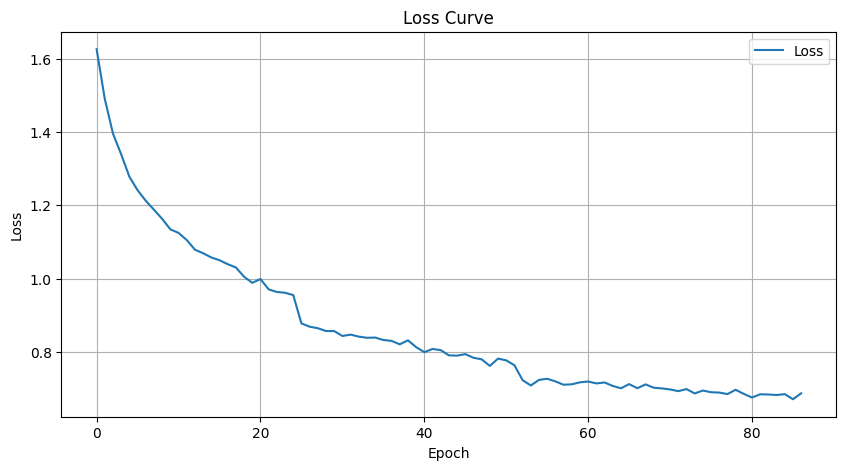

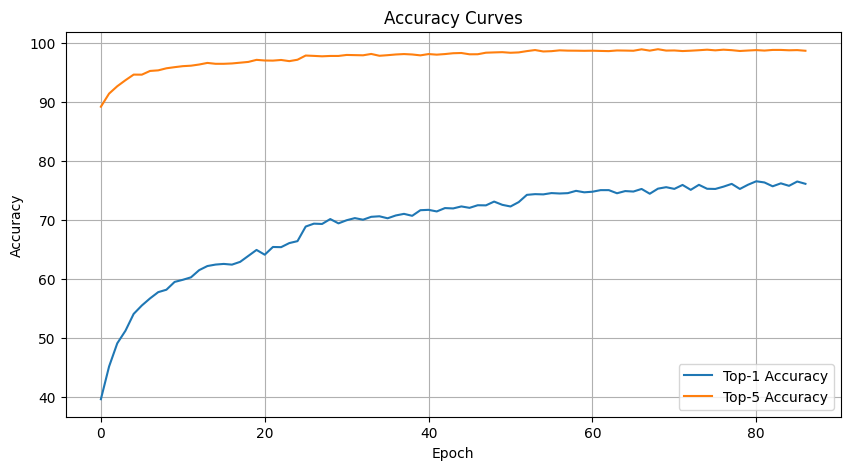

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the output list
epochs_list, loss_list, acc1_list, acc5_list = zip(*output)

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, acc1_list, label='Top-1 Accuracy')
plt.plot(epochs_list, acc5_list, label='Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()